<a href="https://colab.research.google.com/github/anthonymalumbe/KaggleX_Titanic/blob/main/Leveraging_ML_for_Early_Detection_of_COVID_19_through_Chest_Imaging_v001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import subprocess
import tensorflow as tf

def downgrade_tensorflow(desired_version):
    try:
        current_version = tf.__version__
        if current_version == desired_version:
            print(f"TensorFlow is already at version {desired_version}. No downgrade needed.")
        else:
            # Uninstall the current TensorFlow version
            uninstall_command = f"pip uninstall tensorflow -y"
            subprocess.run(uninstall_command, shell=True, check=True)

            # Install the desired TensorFlow version
            install_command = f"pip install tensorflow=={desired_version}"
            subprocess.run(install_command, shell=True, check=True)

            print(f"Successfully downgraded TensorFlow to version {desired_version}")
    except Exception as e:
        print(f"Error: {e}")
#desired_version = "2.9.1"  # Replace with your desired TensorFlow version
#downgrade_tensorflow(desired_version)

!pip uninstall tensorflow
!pip install tensorflow==2.9.1
import tensorflow as tf


Found existing installation: tensorflow 2.9.1
Uninstalling tensorflow-2.9.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.9.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.9.1
  Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)


In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import itertools
import shutil


from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Activation, Flatten
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.regularizers import l2
print(tf.version.VERSION)

import warnings
warnings.filterwarnings("ignore")

2.9.1


Download the COVID-19 Dataset

In [2]:
os.environ['KAGGLE_USERNAME'] = "anthonymalumbe"
os.environ['KAGGLE_KEY'] = "0cb4a0f3fe6d28695713571db2848621"

In [3]:
path = "COVID-QU-Ex Dataset"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)

In [4]:
# defining Path

checkfileexists = '/covidqu.zip'

# Checking whether the specified path exists
isFile = os.path.isfile(checkfileexists)
if not isFile:
  !kaggle datasets download anasmohammedtahir/covidqu

100% 1.15G/1.15G [00:54<00:00, 24.0MB/s]
100% 1.15G/1.15G [00:54<00:00, 22.8MB/s]


Uzip the COVID-19 Dataset zip file

In [5]:
!unzip -n -q covidqu.zip  -d "COVID-QU-Ex Dataset/"

List the number of images in the Lung Segementation Directories

In [2]:
len(os.listdir('COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images'))

2395

In [3]:
len(os.listdir('COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images'))

7658

In [4]:
len(os.listdir('COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images'))

1903

In [5]:
len(os.listdir('COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Test/Normal/images'))

2140

In [6]:
len(os.listdir('COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Train/Normal/images'))

6849

In [7]:
len(os.listdir('COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Val/Normal/images'))

1712

List the number of images in the Infection Segementation Directories

In [8]:
len(os.listdir('COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images'))

583

In [9]:
len(os.listdir('COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images'))

1864

In [10]:
len(os.listdir('COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Val/COVID-19/images'))

466

In [11]:
len(os.listdir('COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/images'))

291

In [12]:
len(os.listdir('COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Train/Normal/images'))

932

In [13]:
len(os.listdir('COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Val/Normal/images'))

233

In [14]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(
        tpu="local")
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
except tf.errors.NotFoundError:
    print("Not running on TPU")
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS:", strategy.num_replicas_in_sync)

Not running on TPU
REPLICAS: 1


Configuration

In [39]:
AUTOTUNE = tf.data.AUTOTUNE

NUM_CLASS = 3
CLASSES = ['COVID-19', 'Non-COVID', 'Normal']
L2_REGULARIZATION = 0.001  # Adjust the regularization strength as needed

IMAGE_SIZE = [224, 224]
LR = 1e-5
EPOCHS = 50
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

TRAINING_PATH = 'COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Train'
TESTING_PATH = 'COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Test'
VALIDATION_PATH = 'COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Val'

Utilities

In [40]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    return numpy_images, np.argmax(numpy_labels, axis=1)

In [41]:
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct


In [42]:
def display_one(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2),
                  color='red' if red else 'black', fontdict={'verticalalignment': 'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

In [43]:
def display_batch(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)

    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols, FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows, cols)*40+3
        # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one(image, title, subplot,
                              not correct, titlesize=dynamic_titlesize)

    # layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [44]:
def display_history(history):
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    ax[0].plot(history.history['loss'], color='b', label="training_loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation_loss", axes=ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'], color='b', label="training_accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r', label="validation_accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()

In [45]:
def display_confusion_matrix(
        cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

DataSet

In [46]:
def create_dataframe(data_dir):
    filenames, labels = [], []
    for fold in os.listdir(data_dir):
        path = os.path.join(data_dir, fold, 'images')
        filelist = [os.path.join(path, filename)
                    for filename in os.listdir(path)]
        filenames.extend(filelist)
        labels.extend([fold] * len(filelist))
    return pd.DataFrame({
        'filename': filenames,
        'label': labels
    })


train_df = create_dataframe(TRAINING_PATH)
val_df = create_dataframe(VALIDATION_PATH)
test_df = create_dataframe(TESTING_PATH)

In [47]:
NUM_TRAINING_IMAGES = len(train_df.index)
NUM_VALIDATION_IMAGES = len(val_df)
NUM_TEST_IMAGES = len(test_df)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(- NUM_VALIDATION_IMAGES // BATCH_SIZE)
TEST_STEPS = -(-NUM_TEST_IMAGES // BATCH_SIZE)

print("Training images:", NUM_TRAINING_IMAGES)
train_label_counts = train_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in train_label_counts.items()]))
print()

print("Validation images:", NUM_VALIDATION_IMAGES)
val_label_counts = val_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in val_label_counts.items()]))
print()

print("Test images:", NUM_TEST_IMAGES)
test_label_counts = test_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in test_label_counts.items()]))

Training images: 3728
COVID-19: 1864, Normal: 932, Non-COVID: 932

Validation images: 932
COVID-19: 466, Normal: 233, Non-COVID: 233

Test images: 1166
COVID-19: 583, Non-COVID: 292, Normal: 291


Data Augmentation

In [48]:
#def data_augment(image, label):
#    image = tf.image.random_flip_left_right(image, 42)
#    image = tf.image.random_brightness(image, 0.1)
#    image = tf.image.random_contrast(image, 0.8, 1.2)##

#    return image, label
factor=0.5
seed=None

def data_augment(image, label):
    # Randomly flip left-right with a given factor and seed
    image = tf.image.random_flip_left_right(image, seed=seed)

    # Randomly adjust brightness with a factor and seed
    image = tf.image.random_brightness(image, max_delta=factor, seed=seed)

    # Randomly adjust contrast with a factor and seed
    image = tf.image.random_contrast(image, lower=1.0 - factor, upper=1.0 + factor, seed=seed)

    return image, label


In [49]:
def get_label(label):
    onehot = label == CLASSES
    return tf.cast(onehot, tf.int32)

In [50]:
def decode_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

In [51]:
def preprocess_path(path, label):
    return decode_image(path), get_label(label)

In [52]:
def load_dataset(df=pd.DataFrame(), ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.Dataset.from_tensor_slices(
        (df['filename'].values, df['label'].values))
    # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(preprocess_path, num_parallel_calls=AUTOTUNE)
    return dataset

In [29]:
#def get_train_dataset(augment=False):
#    dataset = load_dataset(train_df)
#    if(augment):
#        dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
#    dataset = dataset.repeat()
#    dataset = dataset.shuffle(BATCH_SIZE * 100)
#    dataset = dataset.batch(BATCH_SIZE)
          #if (augment):
          #     dataset = dataset.map(lambda x, y: (data_augment(x), y))
          #dataset = dataset.prefetch(AUTOTUNE)

#    return dataset

In [30]:
#def get_validation_dataset(ordered=False):
#    dataset = load_dataset(val_df, ordered=ordered)
#    dataset = dataset.batch(BATCH_SIZE)
#    dataset = dataset.cache()
#    dataset = dataset.prefetch(AUTOTUNE)
#    return dataset

In [53]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(test_df, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [54]:
# I love the  ImageDataGenerator class, it allows us to specifiy whatever augmentations we want so easily...
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
# Note that the validation data should not be augmented!
#and a very important step is to normalise the images through  rescaling
height = 224
width = 224
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    TRAINING_PATH,
    # All images will be resized to target height and width.
    target_size=(height, width),
    batch_size=BATCH_SIZE,
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode="categorical",
)
validation_generator = test_datagen.flow_from_directory(
    VALIDATION_PATH,
    target_size=(height, width),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

Found 11184 images belonging to 3 classes.
Found 2796 images belonging to 3 classes.


Dataset visualisations

In [35]:
#training_dataset = get_train_dataset()
#training_dataset = training_dataset.unbatch().batch(16)
#train_batch = iter(training_dataset)

In [ ]:
# run this cell again for another randomized set of training images
display_batch(next(train_batch))

In [ ]:
print("Training data shapes:")
for image, label in get_train_dataset().take(1):
    print(image.numpy().shape, label.numpy().shape)

print("Validation data shapes:")
for image, label in get_train_dataset().take(1):
    print(image.numpy().shape, label.numpy().shape)

print("Test data shapes:")
for image, label in get_test_dataset().take(1):
    print(image.numpy().shape, label.numpy().shape)

Create a Model

In [55]:
%%time
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'effb7_model.h5',                 # File to save the model weights
    monitor='val_accuracy',           # Monitor validation accuracy
    #monitor='val_loss',               # Monitor validation loss
    verbose=1,                        # Verbosity level (0: no messages, 1: progress bar, 2: one line per epoch)
    save_best_only=True,              # Save only the best model based on the monitored metric
    #save_weights_only=True,           # Save only the model weights, not the whole model
    #mode='max'                        # Mode to determine the best model (max: maximize the monitored metric)
    mode='min'                        # Mode to determine the best model (min: minimize the monitored metric)
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",               # Monitor validation loss
    patience=12,                      # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True         # Restore the model's weights to the best epoch
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",               # Monitor validation loss
    factor=0.2,                       # Reduce learning rate by a factor of 0.2
    patience=3,                       # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7                       # Minimum learning rate
)

CPU times: user 68 µs, sys: 0 ns, total: 68 µs
Wall time: 73.4 µs


In [56]:
with strategy.scope():

      # Create the base EfficientNetB7 model with pre-trained weights
      base_model = EfficientNetB7(
          include_top=False,         # Exclude the top classification layer
          weights='imagenet',        # Pre-trained weights on ImageNet
          input_shape=(224, 224, 3)  # Input shape suitable for your X-ray images
      )
      # Freeze the layers of the base model (optional, you can experiment with this)
      for layer in base_model.layers:
          layer.trainable = False

      # Create a custom head for the model
      # x = GlobalMaxPooling2D()(base_model.output)          # Global max pooling layer
      #x = GlobalAveragePooling2D()(base_model.output)       # Global Averagepooling layer
      #x = Flatten()(x)                                      # Flatten layer
      #x = Dropout(0.5)(x)                                   # Dropout layer with a dropout rate of 50%
      #x = Dense(64, activation='relu')(x)                   # Dense layer with ReLU activation
      #x = Dense(256, activation='relu')(x)                  # Dense layer with ReLU activation
      #x = Dropout(0.5)(x)                                   # Dropout layer with a dropout rate of 30%
      #x = Dropout(0.3)(x)                                   # Dropout layer with a dropout rate of 30%
      #x = Dense(2, activation='relu')(x)                    # Dense layer with ReLU activation
      #x = Dropout(0.2)(x)                                   # Dropout layer with a dropout rate of 20%

      # Set the base model to be trainable
      base_model.trainable = True

      # Add custom layers on top of the base model
      x = GlobalMaxPooling2D()(base_model.output)  # Global Max Pooling 2D
      x = Dropout(0.5)(x)  # Dropout layer with a dropout rate of 0.5

      # Add multiple dense layers with L2 regularization
      x = Dense(512, activation='relu', kernel_regularizer=l2(L2_REGULARIZATION))(x)
      x = Dropout(0.3)(x)  # Dropout layer with a dropout rate of 0.3
      x = Dense(256, activation='relu', kernel_regularizer=l2(L2_REGULARIZATION))(x)
      x = Dropout(0.2)(x)  # Dropout layer with a dropout rate of 0.2

      # Flatten layer
      x = Flatten()(x)

      output = Dense(NUM_CLASS, activation='softmax')(x)  # Output layer

      # Create the custom model by combining the base model and custom head
      model = Model(inputs=base_model.input, outputs=output)

      # Compile the model
      model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=10E-6),
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )

      # Print a summary of the model architecture
      model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

Train The Model

In [57]:
# Train the model with ModelCheckpoint, ReduceLROnPlateau, and EarlyStopping callbacks
history = model.fit(
    #get_train_dataset(augment=True).shuffle(buffer_size=100, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE),
    #steps_per_epoch=STEPS_PER_EPOCH,
    #epochs=EPOCHS,
    #validation_data=get_validation_dataset(),
    #validation_steps=VALIDATION_STEPS,
    #callbacks=[checkpoint, reduce_lr, early_stopping]

    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    verbose=1,
    use_multiprocessing=True,
    workers=4,
)

# Save the model after training
model.save('effb7_model.h5')

Epoch 1/50
233/233 [==============================] - 155s 451ms/step - loss: 3.8853 - accuracy: 0.4217 - val_loss: 4.8755 - val_accuracy: 0.4936
Epoch 2/50
233/233 [==============================] - 99s 421ms/step - loss: 3.1256 - accuracy: 0.4633 - val_loss: 2.3679 - val_accuracy: 0.5487
Epoch 3/50
233/233 [==============================] - 99s 423ms/step - loss: 2.7957 - accuracy: 0.4705 - val_loss: 2.1329 - val_accuracy: 0.6123
Epoch 4/50
233/233 [==============================] - 99s 423ms/step - loss: 2.5692 - accuracy: 0.4882 - val_loss: 2.1216 - val_accuracy: 0.5985
Epoch 5/50
233/233 [==============================] - 99s 420ms/step - loss: 2.4431 - accuracy: 0.4893 - val_loss: 2.1144 - val_accuracy: 0.5731
Epoch 6/50
233/233 [==============================] - 99s 422ms/step - loss: 2.3140 - accuracy: 0.5212 - val_loss: 2.1193 - val_accuracy: 0.5699
Epoch 7/50
233/233 [==============================] - 100s 426ms/step - loss: 2.2538 - accuracy: 0.5319 - val_loss: 2.1389 - val_

Evaluate The Model

<Figure size 640x480 with 0 Axes>

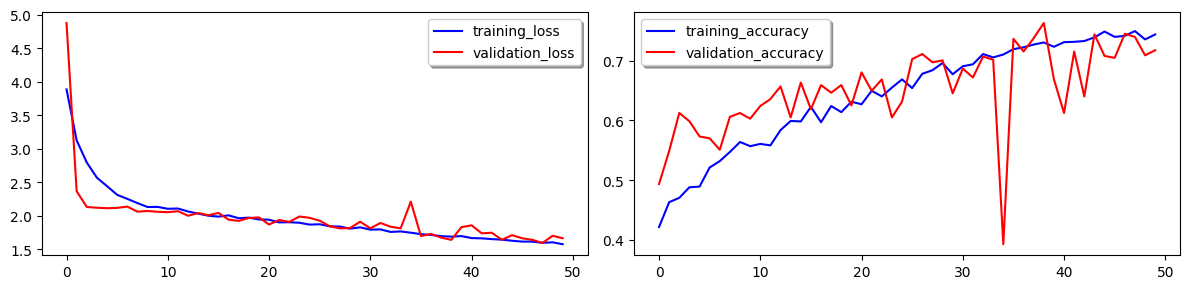

In [58]:
# Display training history (assuming you have a display_history function)
display_history(history)

In [59]:
# Load the saved model
model = tf.keras.models.load_model('effb7_model.h5')

In [60]:
# Get the validation dataset
val_dataset = get_validation_dataset(ordered=True)

# Evaluate the model on the validation dataset
results = model.evaluate(
    val_dataset, batch_size=BATCH_SIZE, steps=VALIDATION_STEPS)

# Print the test loss and test accuracy
print('Test loss: {:4f}'.format(results[0]))
print('Test accuracy: {:4f}'.format(results[1]))

NameError: ignored

In [61]:
# Extract images from the validation dataset
images_ds = val_dataset.map(lambda image, label: image)

# Extract labels from the validation dataset and unbatch them
labels_ds = val_dataset.map(lambda image, label: label).unbatch()

# Get the correct labels as a numpy array
correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()

# Make predictions on the validation dataset
pred = model.predict(val_dataset, steps=VALIDATION_STEPS)

# Get the true labels by finding the index of the maximum value
y_true = np.argmax(correct_labels, axis=-1)

# Get the predicted labels by finding the index of the maximum predicted value
y_pred = np.argmax(pred, axis=-1)

# Print a classification report showing precision, recall, and F1-score
print(classification_report(y_true, y_pred, target_names=CLASSES))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
display_confusion_matrix(cm=cm, classes=CLASSES, title='Confusion Matrix')


NameError: ignored

Test The Model

In [62]:
dataset = get_test_dataset()
dataset = dataset.unbatch().batch(16)
batch = iter(dataset)

1/1 [==============================] - 6s 6s/step


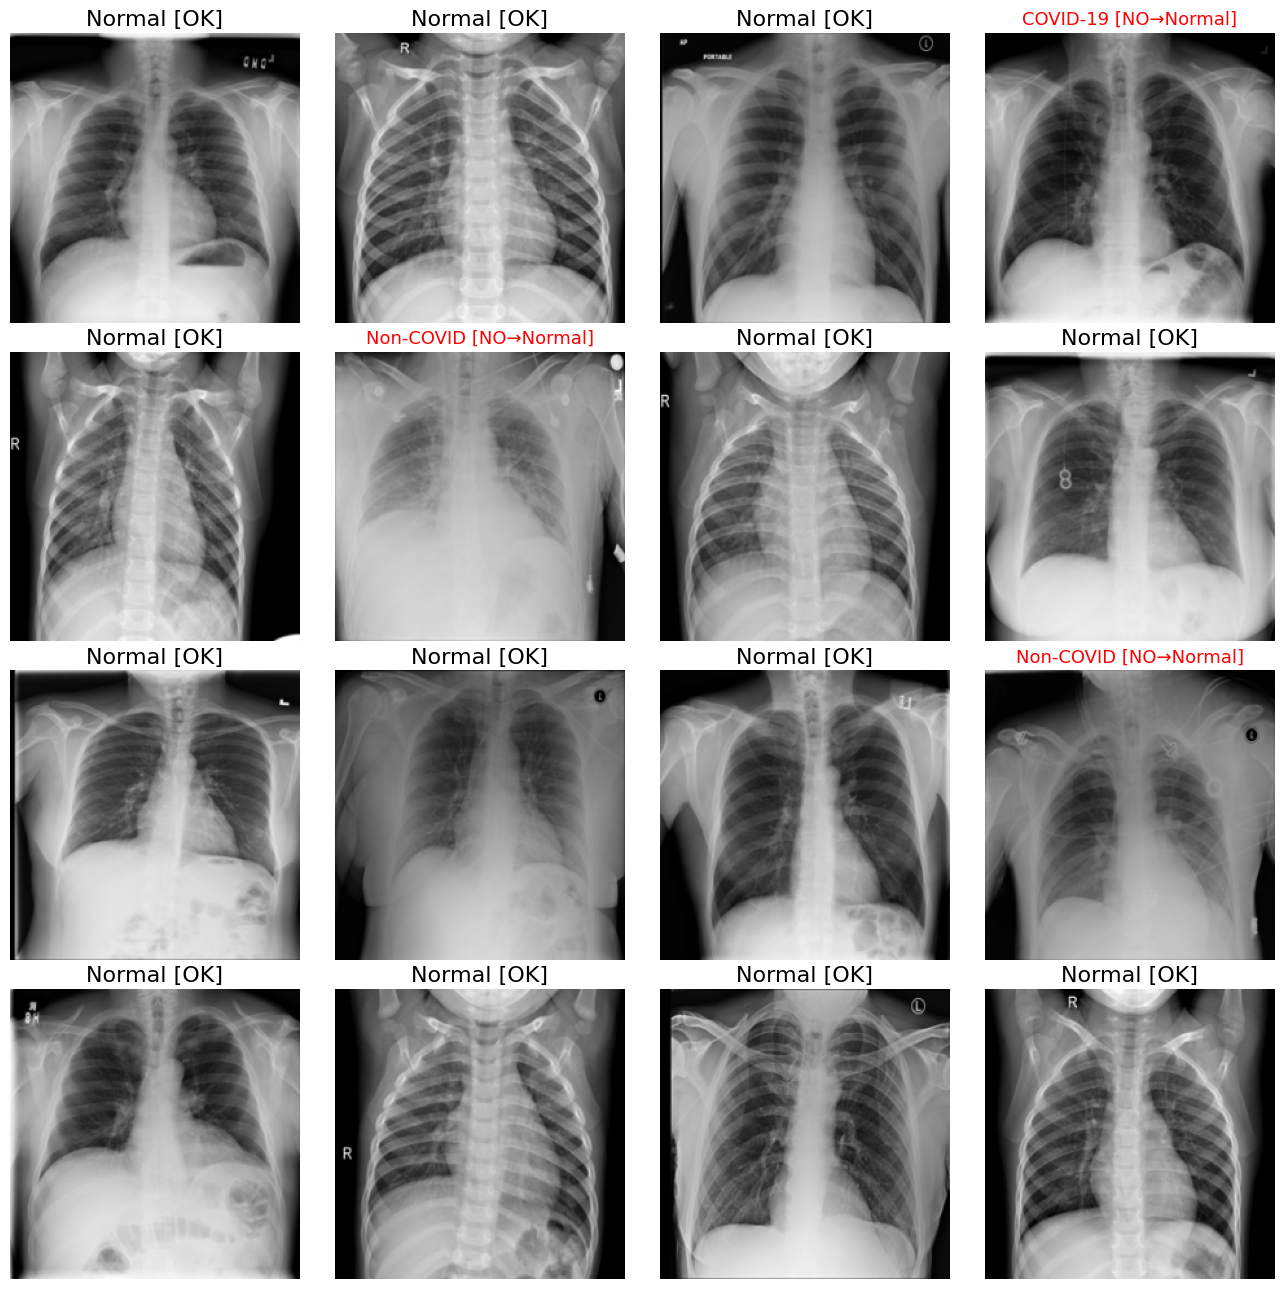

In [63]:
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch((images, labels), predictions)

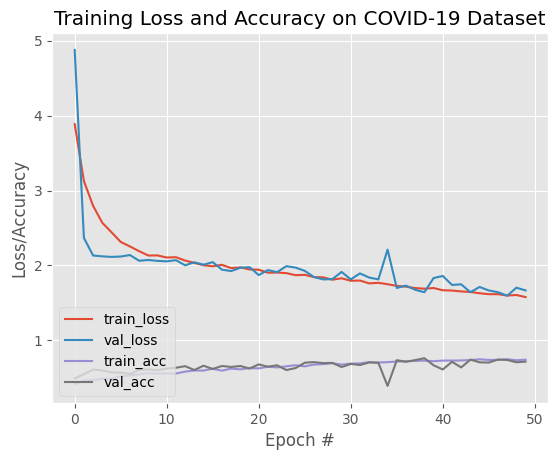

In [65]:
# plot the training loss and accuracy
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")